In [1]:
from display.display_figures import display_data, display_REstim, display_REstim_by_dpt

# For data reading purposes
from include.load_data.get_counts import get_real_counts, get_real_counts_by_county

# For independent denoising
from include.optim_tools.sliding_median import sliding_median

# For Rt estimation
from include.estim.Rt_MLE import Rt_MLE
from include.estim.Rt_Gamma import Rt_Gamma
from include.estim.Rt_Univariate import Rt_U
from include.estim.Rt_UnivariateOutliers import Rt_U_O
from include.estim.Rt_Multivariate import Rt_M

## Univariate reproduction number estimations on real-world infection counts
### Data fetching

Loading univariate infections counts from `dataBasis` (choice between `SPF` (Santé Publique France) and `JHU` (Johns Hopkins University)) and for `country` between
   * `France` for `SPF`
   * any country available for `JHU`

for dates from `firstDay` to `lastDay` both in format 'YYYY-MM-DD'

Opening data from Johns Hopkins University.


C:\Users\juliana\Documents\GitHub\Covid-R-estim\display\display_figures.py:52: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


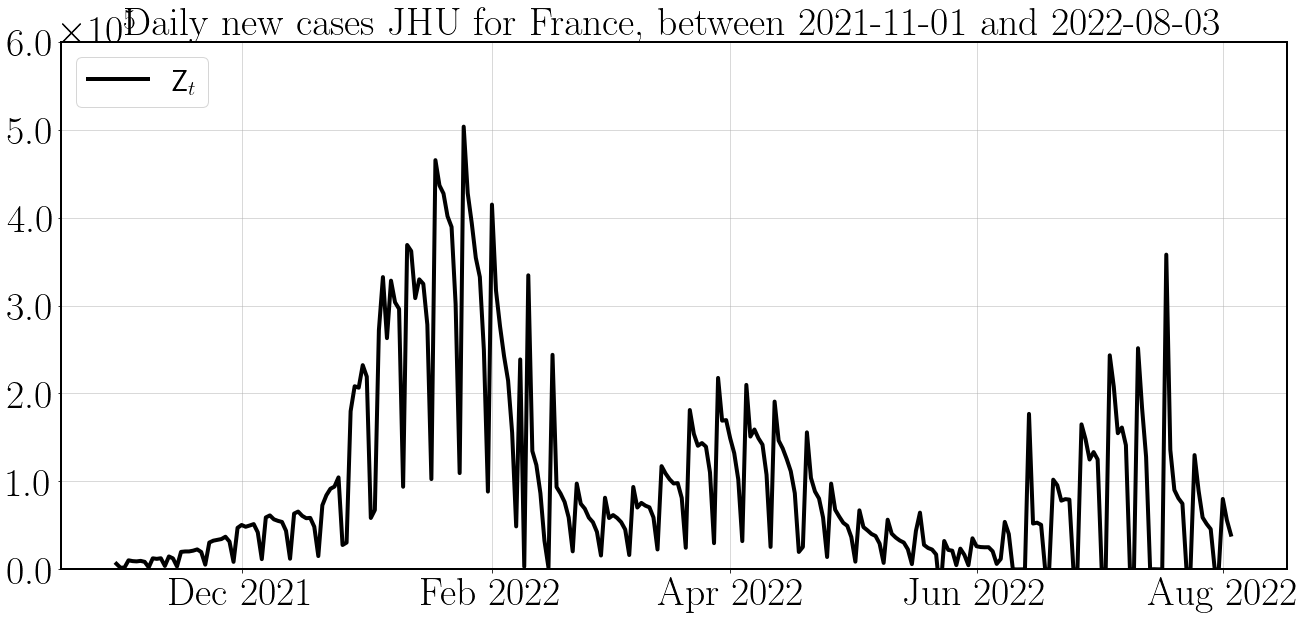

In [2]:
# Choice of country, dates, regularization parameters & computation
dataBasis = 'JHU'
country = 'France'
firstDay = '2021-11-01'  # first day of the chosen time period
lastDay = '2022-08-03'  # last day of the chosen time period

# Fetch data and associated dates
ZData, options = get_real_counts(country, firstDay, lastDay, dataBasis)

display_data(ZData, options=options);

### Maximum Likelihood Estimator

According to the epidemiological model presented in Cori et al., 2013, Am. Journal of Epidemiology [2], the maximum likelihood estimator is
$$ \widehat{\mathsf{R}}_t^{\mathsf{MLE}} = \frac{\mathsf{Z}_t}{\Phi^{\boldsymbol{\mathsf{Z}}}_{t}} $$

where $\Phi^{\boldsymbol{\mathsf{Z}}}_{t} = \sum_{s=1}^{26} \phi(s) \mathsf{Z}_{t - s}$ with the *serial interval function* $\phi$ accounting for the random delay between primary and secondary infection, modeled by a Gamma distribution vanishing after 26 days.

Computing Maximum Likelihood Estimator (MLE) ...
Done in 0.0000 seconds ---


C:\Users\juliana\Documents\GitHub\Covid-R-estim\display\display_figures.py:188: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


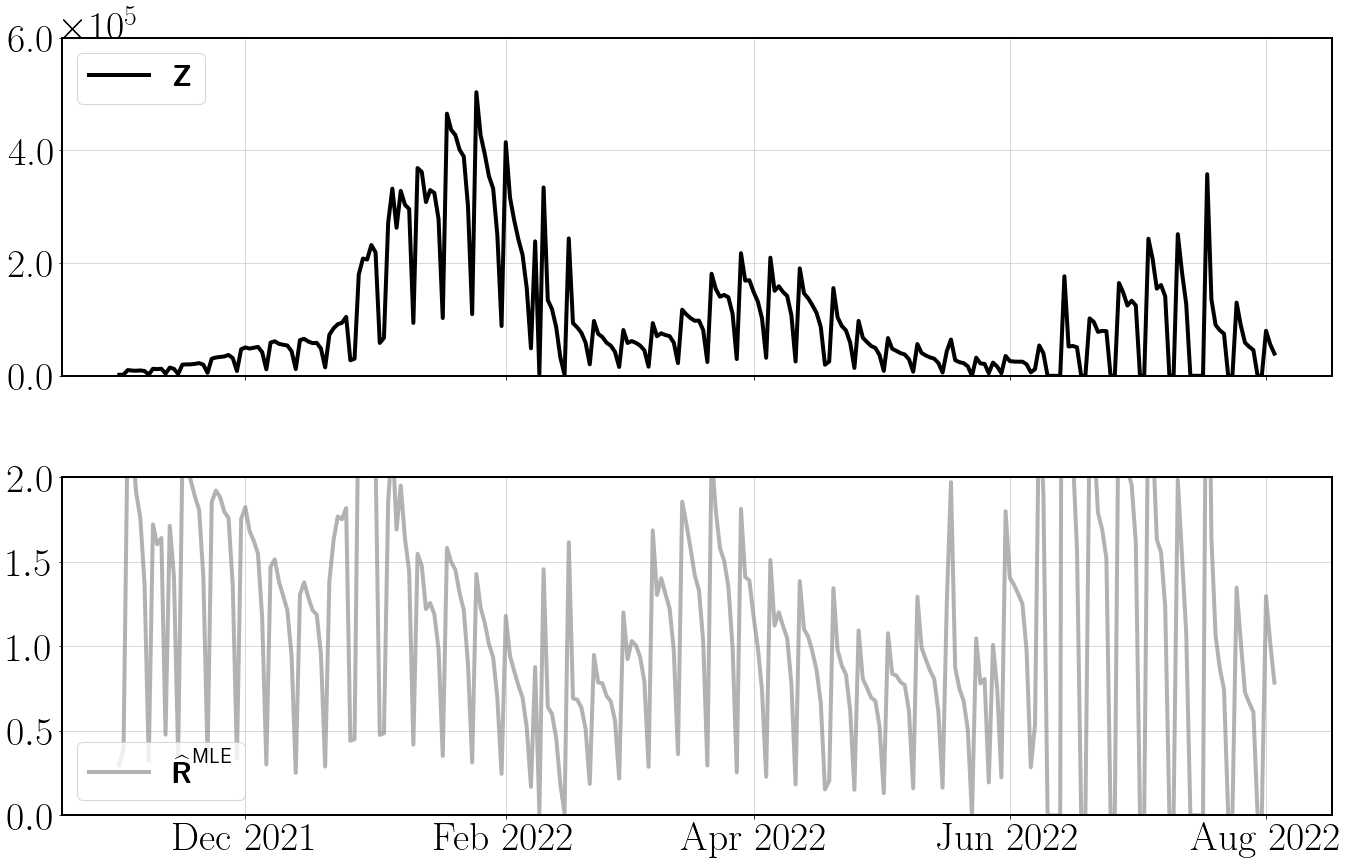

In [3]:
# Analytic computation
Rt_MLE, options_MLE = Rt_MLE(ZData, options=options)

# Display figures
display_REstim(Rt_MLE, options_MLE);

### Bayesian Estimator

Following Cori et al., 2013, Am. Journal of Epidemiology [2], R estimation is made using Bayesian framework resulting in:

$$\widehat{\mathsf{R}}_t^\Gamma = \frac{1 + \sum_{s=t-\tau}^{t}\mathsf{Z}_s}{5 + \sum_{s=t-\tau}^{t}\Phi^{\boldsymbol{\mathsf{Z}}}_{s}}$$

Here $\tau = 15$

Computing Bayesian estimator ...
Done in 0.0000 seconds ---


C:\Users\juliana\Documents\GitHub\Covid-R-estim\display\display_figures.py:188: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


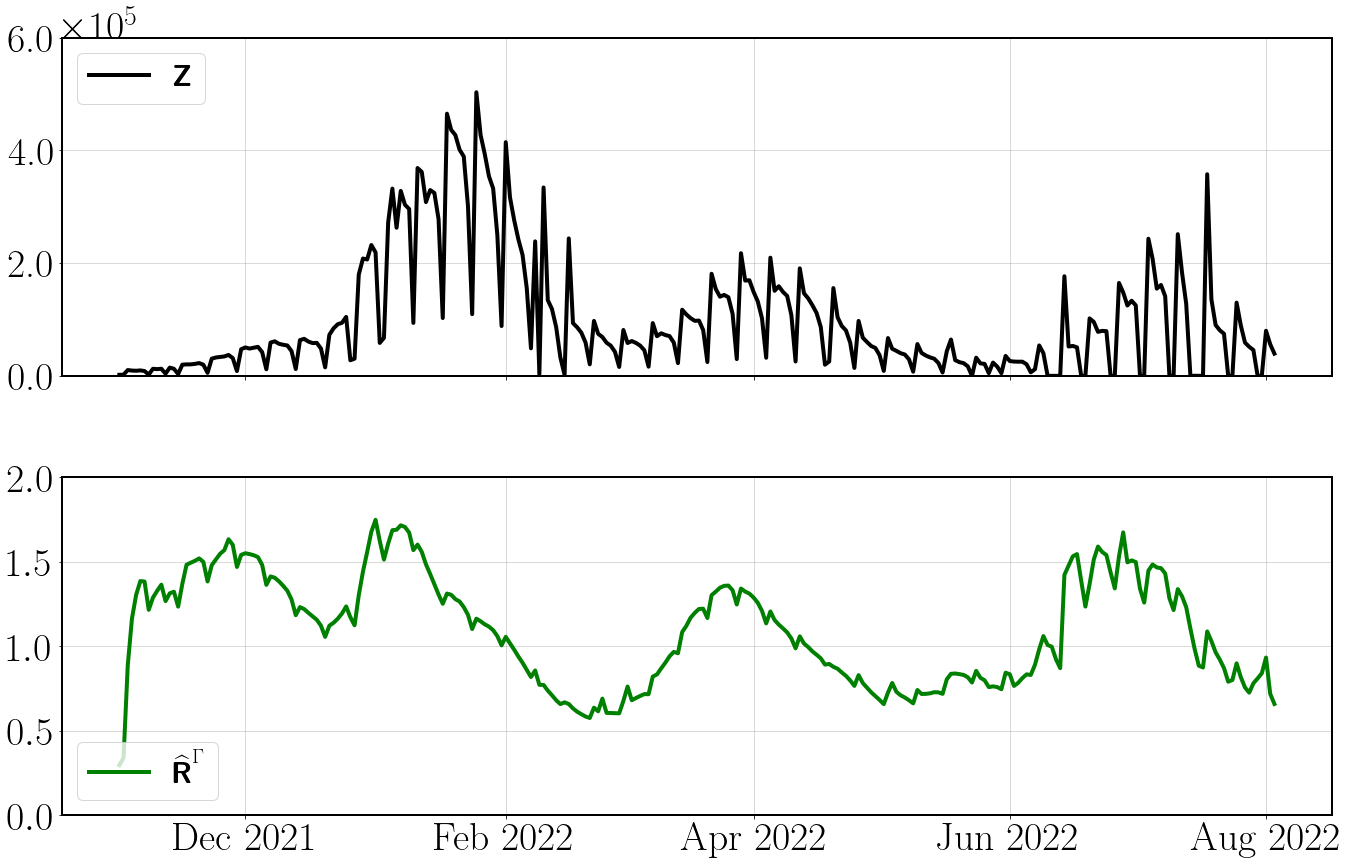

In [4]:
# Choice of the hyperparameter
tau = 15

# Analytic computation
Rt_Gamma, options_Gamma = Rt_Gamma(ZData, tau=tau, options=options)

# Display results
display_REstim(Rt_Gamma, options_Gamma);

### Univariate estimation

1. Pre-processing with a sliding median in [5], <b> not performed in </b> [6]:
    $\mathsf{Z}^{(\alpha)} =$ `sliding_median`$(\mathsf{Z}; \alpha)$
    &nbsp;

    with $\alpha \geq 0$ chosen according to the heuristics:
    - small $\alpha$: processing a lot of counts
    - great $\alpha$: processing few counts

2. Solving the Univariate variational problem with Chambolle-Pock algorithm

    $$ \widehat{\boldsymbol{\mathsf{R}}}^{\mathsf{U}} = \underset{\boldsymbol{\mathsf{R}} \in \mathbb{R}_+^{ T}}{\mathrm{argmin}} \,\mathrm{D}_{\mathsf{KL}}(\boldsymbol{\mathsf{Z}}^{(\alpha)} | \boldsymbol{\mathsf{p}}) + \lambda_{\mathsf{L}}^{\mathsf{U}} \lVert \mathsf{L} \boldsymbol{\mathsf{R}}\rVert_1 , \quad \mathsf{p}_t = \mathsf{R}_t \Phi^{\boldsymbol{\mathsf{Z}}}_t$$

with $\mathsf{L}$ the discrete second-order differential operator.

Computing Univariate estimator ...
Done in 5.4883 seconds ---


C:\Users\juliana\Documents\GitHub\Covid-R-estim\display\display_figures.py:188: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


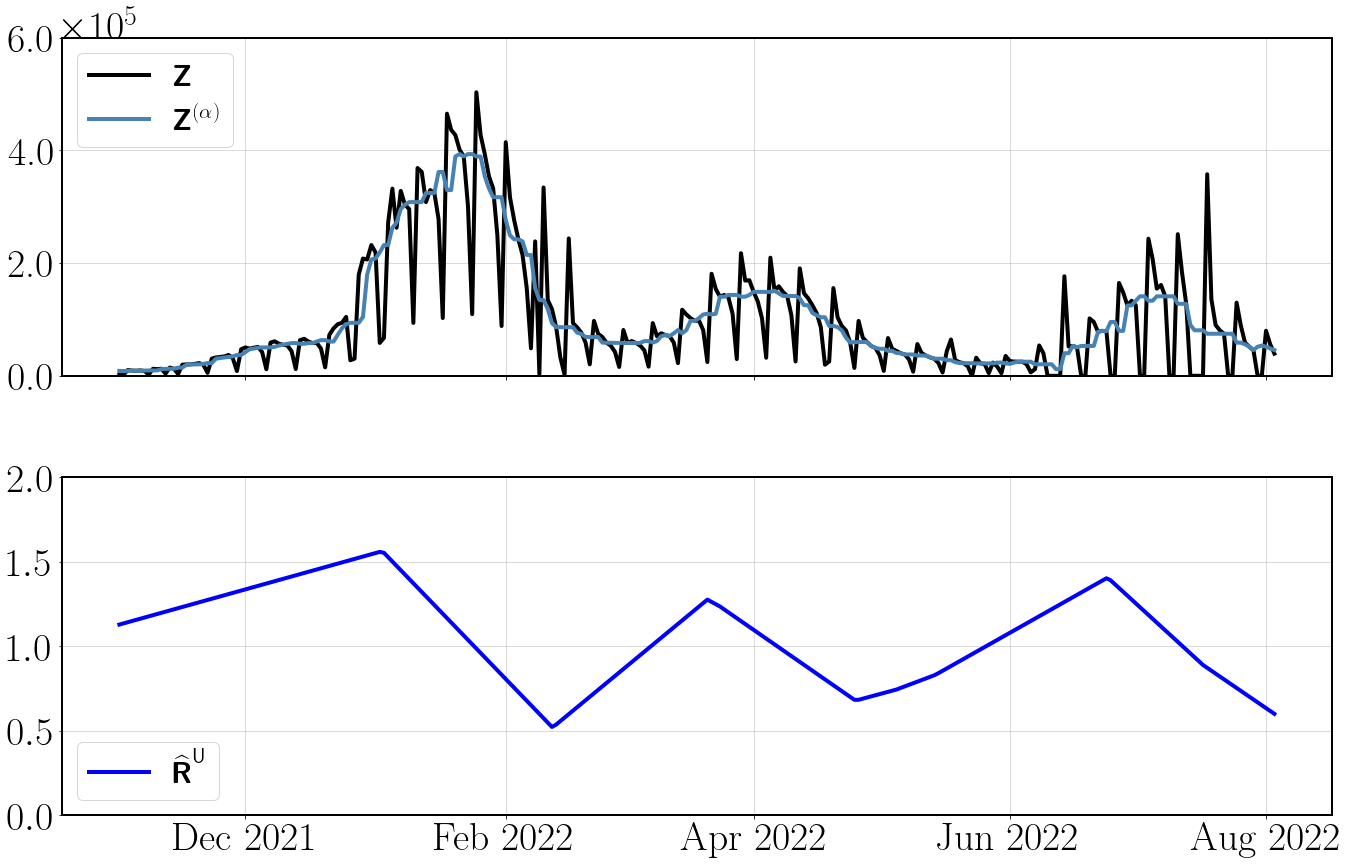

In [5]:
# Choice of denoising parameter alpha and regularization parameter muR
alpha = 0.1
lambdaU_L = 50

# Denoising with sliding median then solving with Chambolle-Pock algorithm
Z_alpha = sliding_median(ZData, alpha)
Rt_U, options_U = Rt_U(Z_alpha, lambdaU_L, options=options)

# Display results
display_REstim(Rt_U, options_U);

### Univariate reproduction number estimator including misreported counts correction

Solving the following Univariate variational estimator with temporal regularization with misreported counts O explicit modelisation (only in [5]), using Chambolle-Pock algorithm

$$\widehat{\boldsymbol{\mathsf{R}}}^{\mathsf{U-O}}, \widehat{\boldsymbol{\mathsf{O}}}^{\mathsf{U-O}} = \, \underset{\boldsymbol{\mathsf{R}} \in \mathbb{R}_+^{ T}, \boldsymbol{\mathsf{O}} \in \mathbb{R}^{ T}}{\mathrm{argmin}} \,\mathrm{D}_{\mathsf{KL}}(\boldsymbol{\mathsf{Z}} | \boldsymbol{\mathsf{p}}) + \lambda_{\mathsf{L}}^{\mathsf{U}} \lVert \mathsf{L} \boldsymbol{\mathsf{R}}\rVert_1 + \lambda_\mathsf{O}^\mathsf{U} \lVert \mathsf{O}\rVert_1 , \quad \mathsf{p}_t = \mathsf{R}_t \Phi^{\boldsymbol{\mathsf{Z}}}_t$$

* A greater $\lambda_\mathsf{L}^\mathsf{U}$ means less slope ruptures
* A greater $\lambda_\mathsf{O}^\mathsf{U}$ means less misreported counts to be estimated

For more examples, see [include/settings.RegularizationSettings](include/settings.py)

Computing Univariate estimation with O misreported counts modelisation ...
iter 100000.000000 	 crit=3.021424 

Done in 45.2708 seconds ---


C:\Users\juliana\Documents\GitHub\Covid-R-estim\display\display_figures.py:188: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


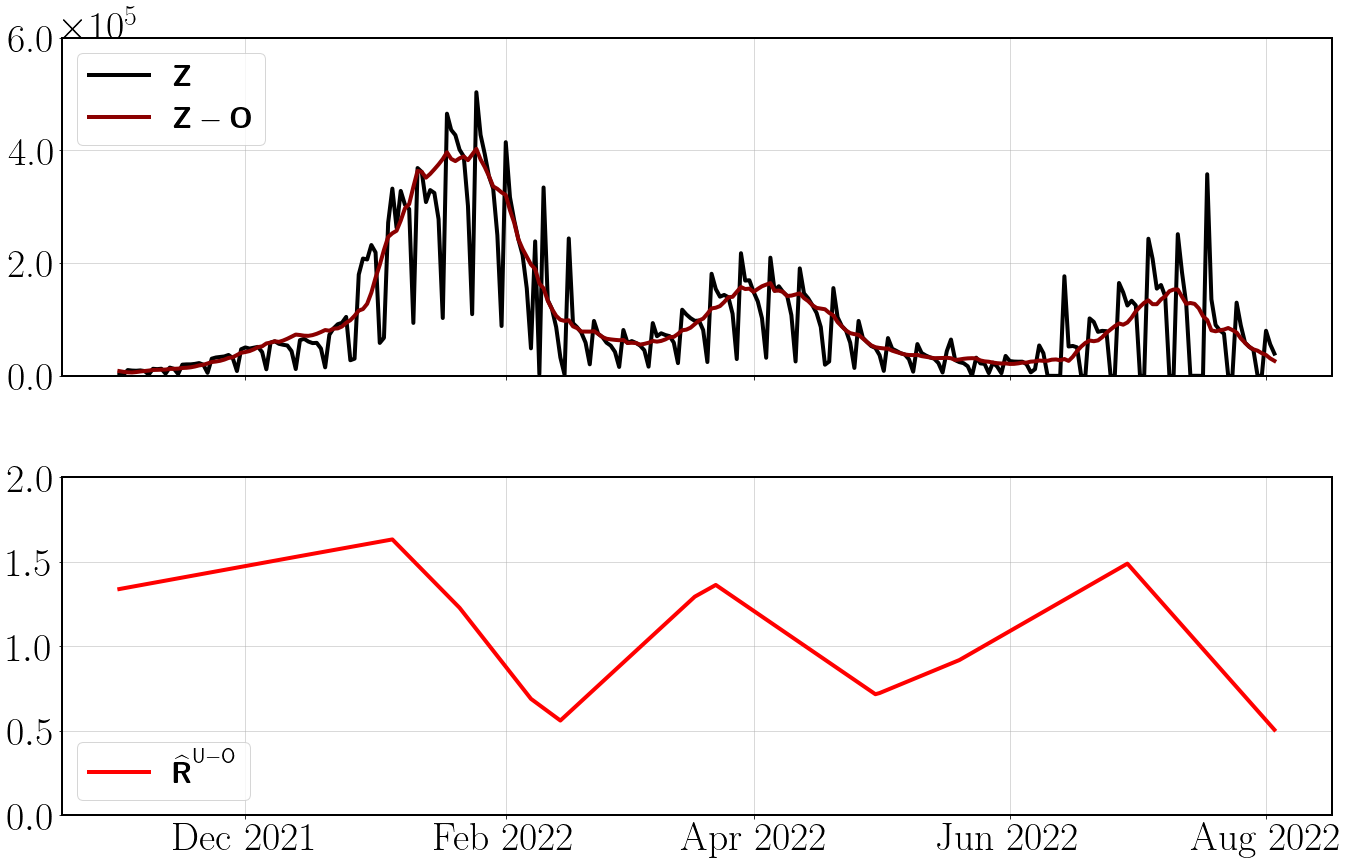

In [6]:
# Choice of denoising parameter alpha and regularization parameter muR
lambdaU_L = 3.5
lambdaU_O = 0.03

# Solving with Chambolle-Pock algorithm
Rt_UO, Ot_UO, options_UO = Rt_U_O(ZData, lambdaU_L, lambdaU_O, options=options)

# Display results
display_REstim(Rt_UO, options=options_UO);

### Summary of univariate estimations

C:\Users\juliana\Documents\GitHub\Covid-R-estim\display\display_figures.py:188: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


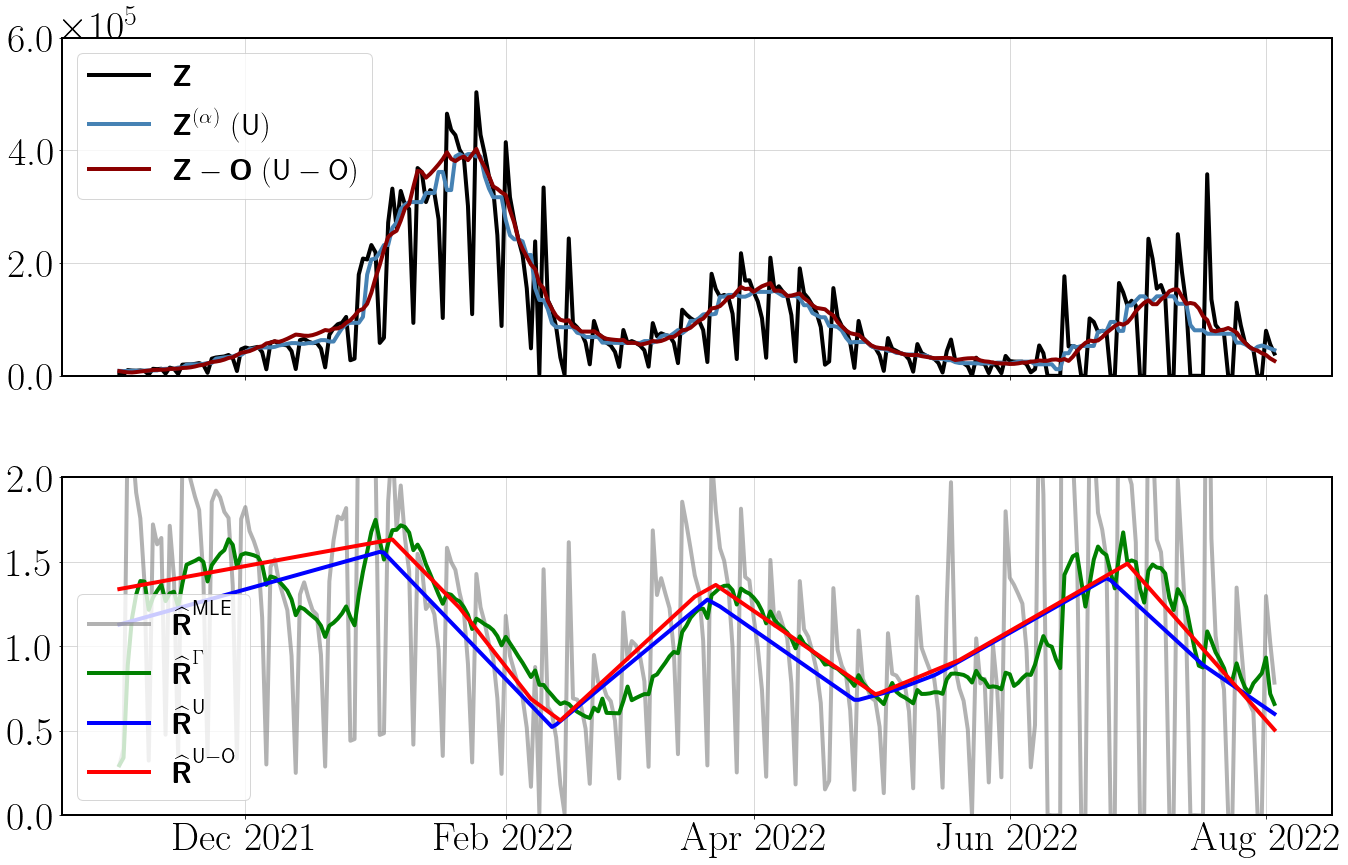

In [7]:
# Gather all methods
REstimations = {'MLE': Rt_MLE, 'Gamma': Rt_Gamma, 'U': Rt_U, 'U-O': Rt_UO}
optionsAll = {'MLE': options_MLE, 'Gamma': options_Gamma, 'U': options_U, 'U-O': options_UO}

# Display comparison between methods
display_REstim(REstimations, optionsAll, comparison=True);

## Multivariate reproduction number estimations on real-world infection counts

### Data fetching

Infection counts are loaded for each of the 96 metropolitan french county (*départements*) in `ZData_multi` $\in \mathbb{N}^{96\times T}$, and $T$ days chosen between `firstDay` and `lastDay`.

In [8]:
# Choice of dates
firstDay = '2021-11-03'
lastDay = '2022-03-04'

# Retrieve associated infection counts by county
ZData_multi, optionsSpat = get_real_counts_by_county(firstDay, lastDay)

### Multivariate estimation
    $$ \widehat{\boldsymbol{\mathsf{R}}}^{\mathsf{M}} = \, \underset{\boldsymbol{\mathsf{R}} \in \mathbb{R}_+^{C\times T}}{\mathrm{argmin}} \,\mathrm{D}_{\mathsf{KL}}(\boldsymbol{\mathsf{Z}} | \boldsymbol{\mathsf{p}}) + \lambda_{\mathsf{L}}^{\mathsf{M}} \lVert \mathsf{L} \boldsymbol{\mathsf{R}}\rVert_1 + \lambda_{\mathsf{G}}^{\mathsf{M}} \lVert \mathsf{G} \boldsymbol{\mathsf{R}}\rVert_1, \quad \mathsf{p}_t = \mathsf{R}_t \Phi^{\boldsymbol{\mathsf{Z}}}_t$$

where
* $\mathsf{L}$ computes the time second-order derivative independently on each time series
* $\mathsf{G}$ encodes the connectivity between counties (here, sharing terrestrial borders counties).

* $\lambda_\mathsf{L}^\mathsf{M} > 0 \,$ (resp. $\lambda_\mathsf{G}^\mathsf{M} > 0$) controls the level of regularity in time (resp. in space) enforced.

In [9]:
# Choice of regularization parameters
lambdaM_L = 50  # temporal regularization
lambdaM_G = 0.005  # spatial regularization

# This computation takes up to 18 minutes ! -------------------------
REstimate, options_M = Rt_M(ZData_multi, lambdaM_L, lambdaM_G, optionsSpat)

Computing Multivariate estimator ...
iter 100000.000000 	 crit=1458.709961 

iter 200000.000000 	 crit=1458.267693 

iter 300000.000000 	 crit=1458.113580 

iter 400000.000000 	 crit=1458.041812 

Done in 883.9419 seconds ---


C:\Users\juliana\Documents\GitHub\Covid-R-estim\display\display_figures.py:461: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


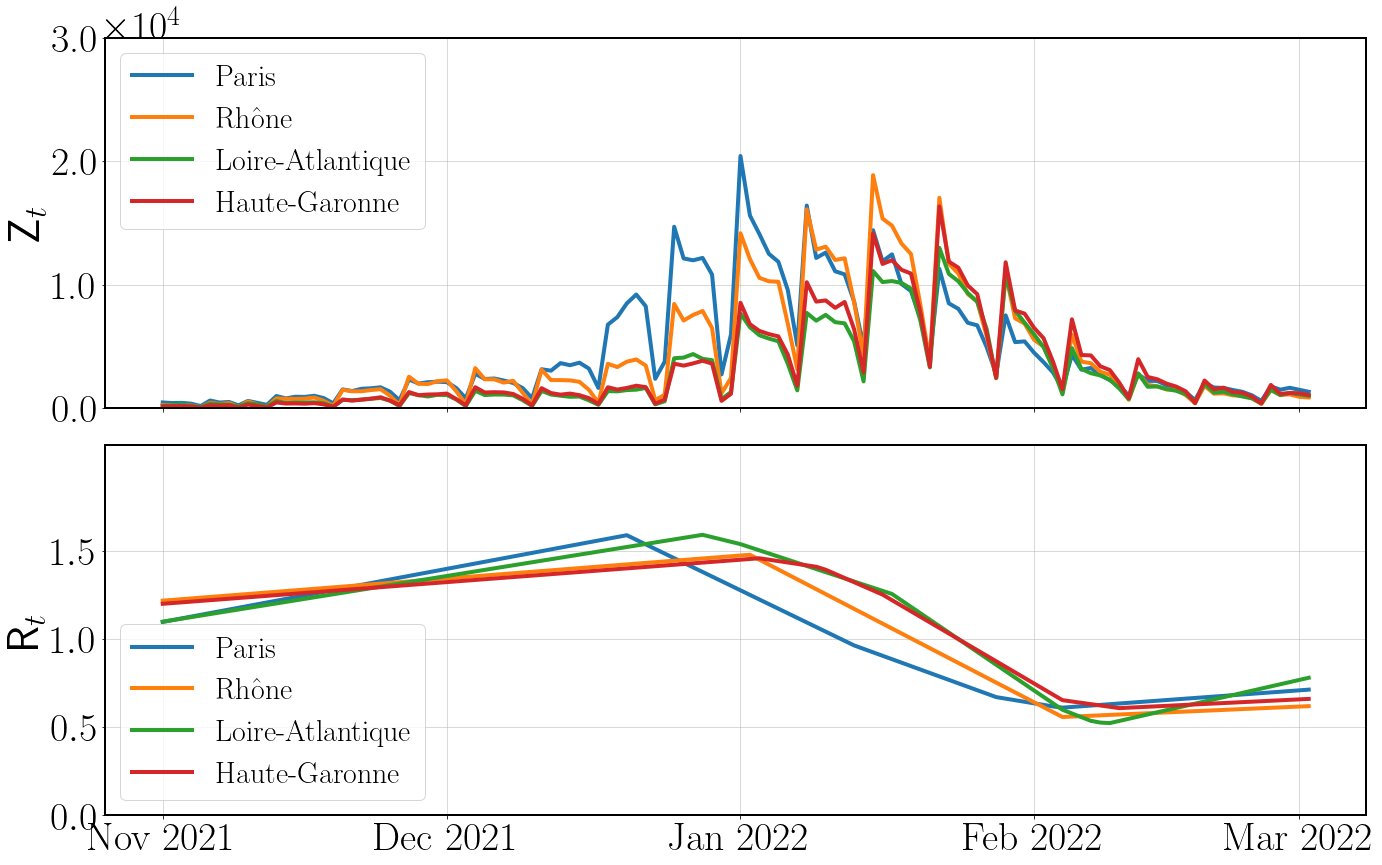

In [10]:
# Displaying selected counties by using their "code" (see https://fr.wikipedia.org/wiki/Num%C3%A9rotation_des_d%C3%A9partements_fran%C3%A7ais).
selectedCounties = ['75', '69', '44', '31']
display_REstim_by_dpt(REstimate, selectedCounties, options_M);